# 🧥 Fashion-MNIST Classification with MLP (No CNN!)
In this notebook, we'll train a simple **Multi-Layer Perceptron (MLP)** on the **Fashion-MNIST** dataset using PyTorch. This serves as a final step before moving to **Convolutional Neural Networks (CNNs)**.

In [664]:
from itertools import islice

import matplotlib.pyplot as plt
import torch
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [665]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps"  if torch.backends.mps.is_available() else
    "cpu"
)
arrow = '$\u2193$'

In [666]:
def imshow_with_title(img, title, color, ax=plt):
    img = img.squeeze()
    ax.imshow(img, cmap='gray')
    ax.set_title(title, color=color, fontsize=14, pad=10, loc='center')
    ax.axis('off')

def infer_targets_from_source(source, samples):
    # Try to get class names from dataset or use fallback
    class_names = getattr(getattr(source, "dataset", source), "classes", None)
    if class_names is None:
        class_names = [f"Class: {i}" for i in range(100)]
    return [class_names[label] for _, label in samples]


def sample_iterator(source):
    # De-batchify: Return the items or, if element is a batch,
    #   all the items from the batch one by one.
    try:
        for batch in source:
            images, labels = batch
            yield from zip(images, labels, strict=True)
    except (TypeError, ValueError):
        yield from (source[i] for i in range(len(source)))


def extract_samples_list(source, n_samples):
    try:
        # Assume source is already a list of (img_tensor, label)
        samples = source[:n_samples]
        _ = samples[0][0].shape  # Confirm structure: (tensor, label)
    except Exception:
        # Fallback to generic iterator (DataLoader or Dataset)
        samples = list(islice(sample_iterator(source), n_samples))
    return samples


def show_in_plot(dims, source, targets=None, title_colors=None):
    """
    Display images from a dataset, dataloader, or list of image-label pairs in a grid.

    Parameters
    ----------
    dims : tuple of (int, int)
        Grid dimensions as (columns, rows).
    source : Dataset or DataLoader or list of tuples
        The data source to visualize. Must yield (image_tensor, label) pairs.
    targets : list, optional
        Optional list of labels to override those in the data.
    title_colors : list, optional
        Optional list of colors to use for titles above each image.

    Returns
    -------
    None
    """
    cols, rows = dims
    total = cols * rows
    figsz = [2.5 * cols, 3 * rows]

    # Create the grid
    fig, axes = plt.subplots(rows, cols, figsize=figsz)
    axes = axes.flatten()

    samples = extract_samples_list(source, total)

    # If targets not given, infer them
    targets = targets or infer_targets_from_source(source, samples)

    # Iterate over all boxes in the grid and fill them.
    for i, ax in enumerate(axes[:len(samples)]):
        img_tensor, _ = samples[i]
        img = img_tensor.squeeze().numpy()

        title = targets[i]
        color = title_colors[i] if title_colors else "blue"
        imshow_with_title(img, title, color, ax)

    plt.tight_layout(h_pad=2.0)


In [667]:
transform_unchanged = transforms.Compose([transforms.ToTensor()])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [668]:
# new_classes = ["TopWear", "Lower/FullWear", "ShoeWear", "Accessories"]
# # label mapping: 10 classes → 4 classes
# label_mapping = {
#     0: 0,  # T-shirt/top → TopWear
#     1: 1,  # Trouser → Lower/FullWear
#     2: 0,  # Pullover → TopWear
#     3: 1,  # Dress → Lower/FullWear
#     4: 0,  # Coat → TopWear
#     5: 2,  # Sandal → ShoeWear
#     6: 0,  # Shirt → TopWear
#     7: 2,  # Sneaker → ShoeWear
#     8: 3,  # Bag → Accessories
#     9: 2,  # Ankle boot → ShoeWear
# }

output_dim = 10


In [669]:
# Load Fashion-MNIST with standard transform.

train_data = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=train_transform,
    # target_transform=lambda y: label_mapping[y],
) # train_transform
test_data = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=train_transform,
    # target_transform=lambda y: label_mapping[y],
) #transform_unchanged


In [670]:
# Override the class names
# train_data.classes = new_classes
# test_data.classes = new_classes


In [671]:
BATCH_SIZE = 64 # 1
train_clean_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_clean_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [672]:
# Verify the transformation works
print("Original targets (.targets attribute):")
print(train_data.targets[:15])  # Still 0-9

print("\nTransformed labels (via DataLoader):")
images, labels = next(iter(train_clean_loader))
print(labels[:15])  # Now 0-3

print(f"\nLabel range: {labels.min()} to {labels.max()}")  # Should be 0 to 3
print(f"Unique classes: {labels.unique()}")  # Should be [0, 1, 2, 3]


Original targets (.targets attribute):
tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7])

Transformed labels (via DataLoader):
tensor([8, 9, 9, 7, 2, 3, 8, 2, 2, 3, 6, 2, 9, 7, 6])

Label range: 0 to 9
Unique classes: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


# Setup the rest of the code which will be using `current_train_loader` and `current_test_loader` for the experiments.

In [673]:
current_train_loader = train_clean_loader
current_test_loader =  test_clean_loader

# current_train_loader = train_augmented_loader #train_clean_loader
# current_test_loader = test_augmented_loader # test_clean_loader

### How `Dataset` and `DataLoader` Work Together



        +----------------------------+         wrapped by         +-------------------------------+
        |         Dataset            |  <------------------------  |         DataLoader            |
        |     (e.g., train_data)     |                             |      (e.g., train_loader)     |
        +----------------------------+                             +-------------------------------+
        | .data                      |                             |                               |
        | .targets                   |                             | ➜ .dataset → access Dataset   |
        | __getitem__(index)         | ◄── DataLoader calls this   | ➜ __iter__() yields batches   |
        | __len__()                  |                             |    of (x, y)                  |
        +----------------------------+                             +-------------------------------+



# How to access the `Dataset` properties when they are wrapped in a `DataLoader`

| Original Access                  | Equivalent via DataLoader                  | Notes                                     |
|----------------------------------|--------------------------------------------|-------------------------------------------|
| `train_data.data.shape`          | `train_loader.dataset.data.shape`          | Accesses shape of raw image data          |
| `train_data.targets.shape`       | `train_loader.dataset.targets.shape`       | Accesses shape of labels tensor           |
| `train_data.targets.dtype`       | `train_loader.dataset.targets.dtype`       | Accesses dtype of labels (typically int64)|


In [674]:
# Original access: train_data.classes, train_data.class_to_idx

# New access:
current_train_loader.dataset.classes, current_train_loader.dataset.class_to_idx

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 {'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9})

In [675]:
# Original: train_data.data.shape, train_data.targets.shape, train_data.targets.dtype

# New access:
current_train_loader.dataset.data.shape, current_train_loader.dataset.targets.shape, current_train_loader.dataset.targets.dtype

(torch.Size([60000, 28, 28]), torch.Size([60000]), torch.int64)

In [676]:
train_data.targets.min(), train_data.targets.max()

(tensor(0), tensor(9))

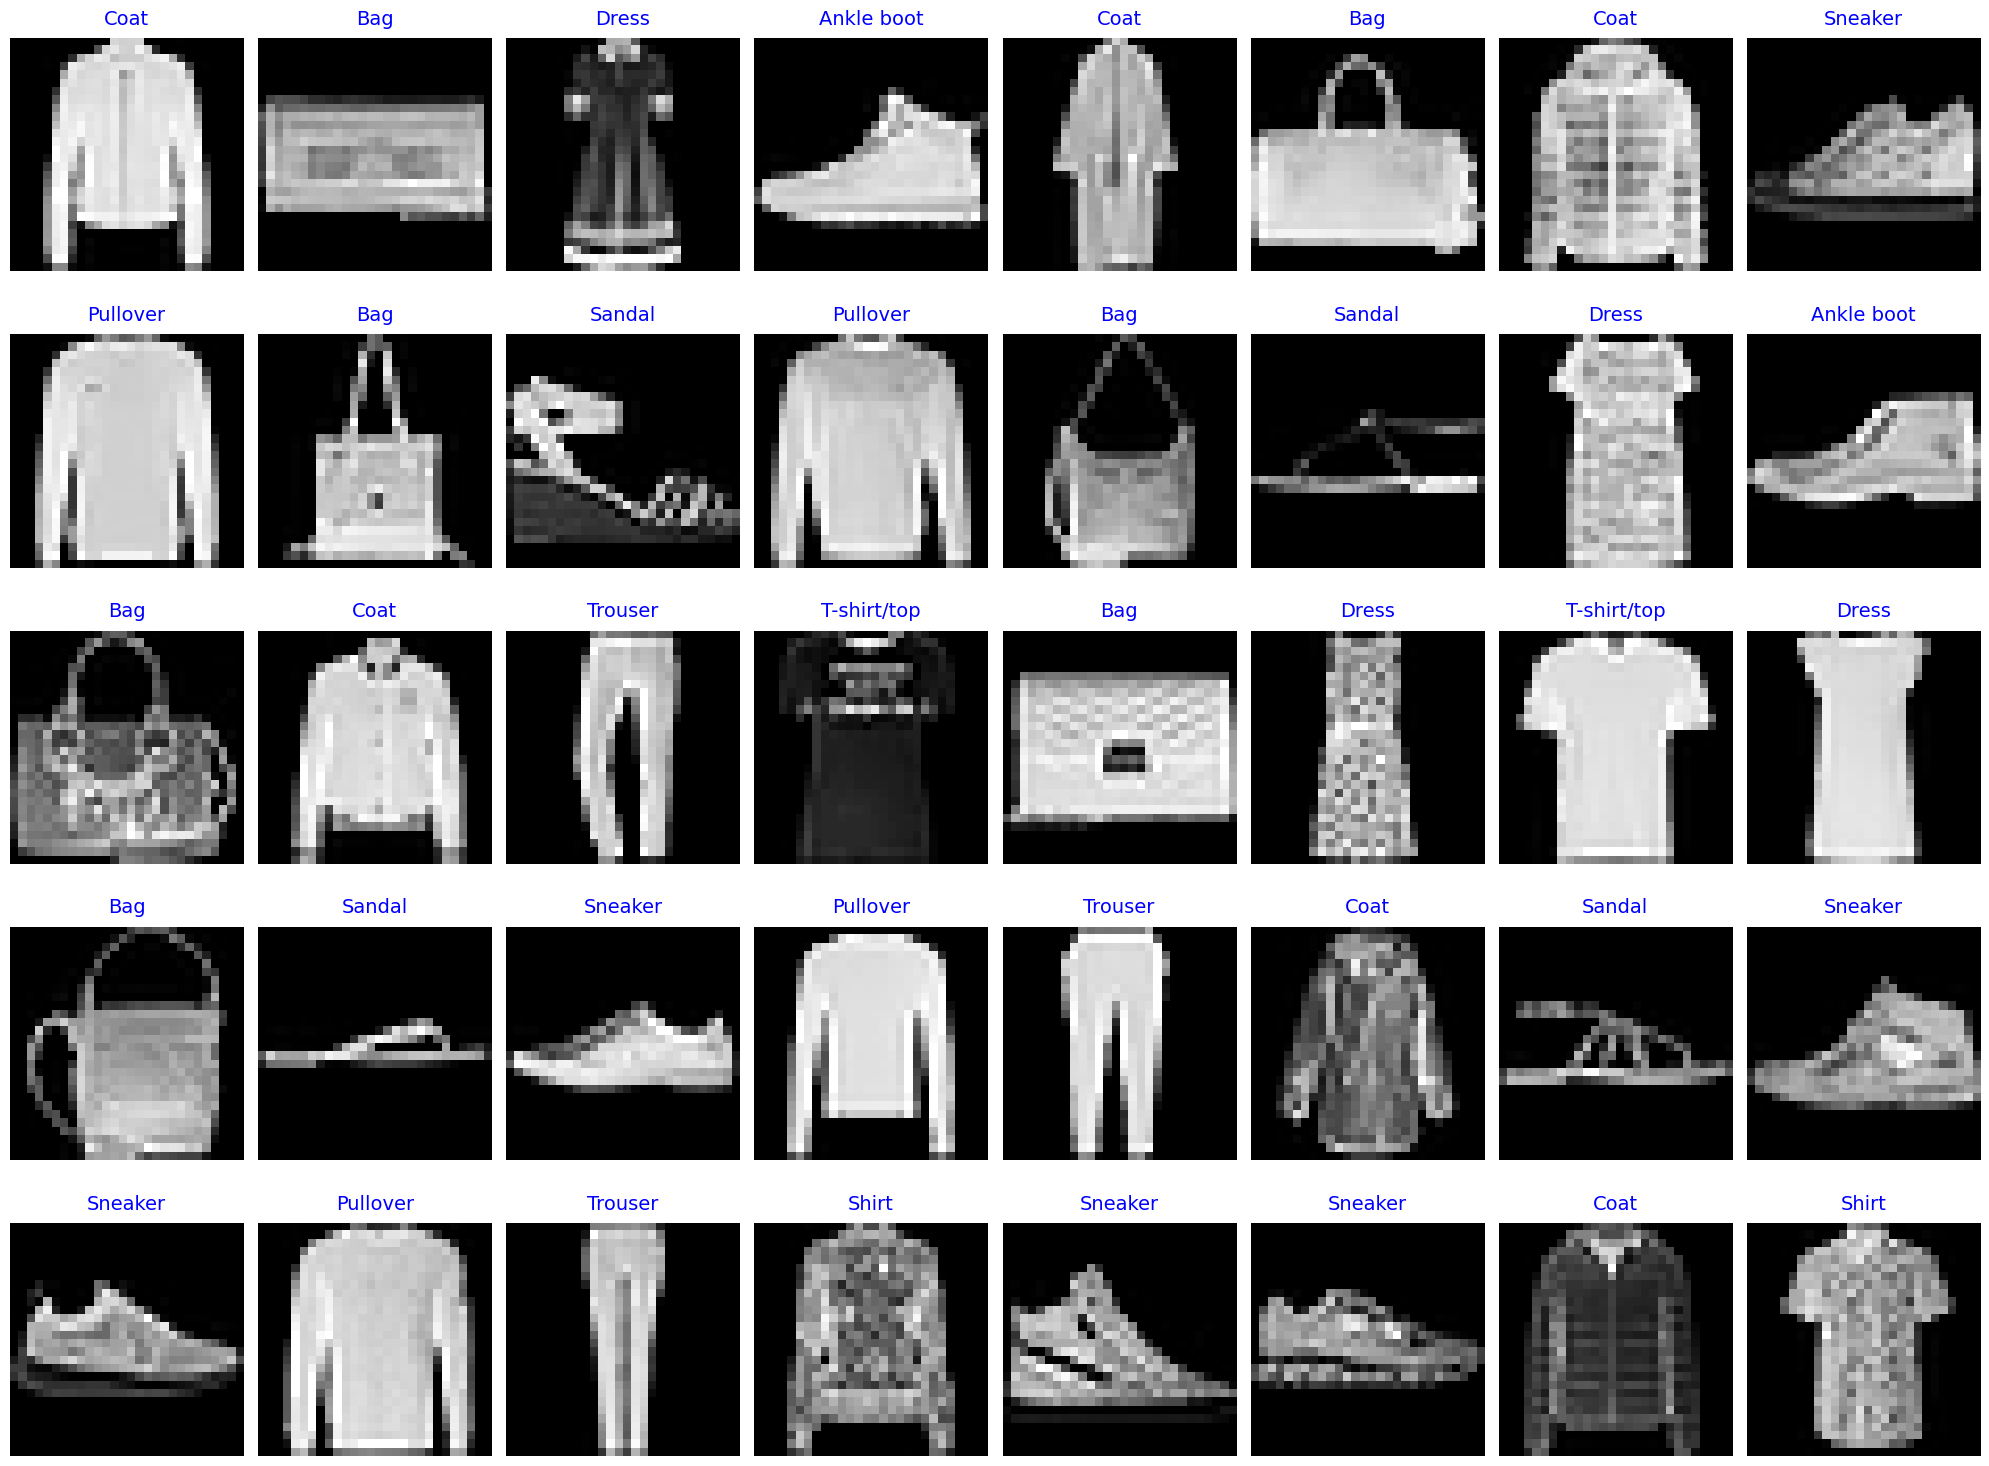

In [677]:
figure_dims = (8,5)  # 8 rows, 5 columns
show_in_plot(figure_dims, current_train_loader, None)

# Training and evaluation loops, as seen in class

In [678]:
def train_model(num_epochs, model, train_loader, loss_fn, optimizer, device):
  # Train the model
  for epoch in range(num_epochs):
      total_loss = 0
      model.train()
      for images, labels in train_loader:
          # The iterator returns a pair  (images,labels):
          # Images size will be:  (28,28,64) and labels : (1,64)

          # Using images.to(device)
          #  This loads the data into device memory (e.g. GPU)
          images, labels = images.to(device), labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = loss_fn(outputs, labels)

          # Backward pass (backpropagation)
          optimizer.zero_grad()
          loss.backward()
          # Update the weights according to the derivatives
          optimizer.step()

          total_loss += loss.item()
          # print(f"    Epoch {epoch+1}, Temporary Loss: {loss.item():.4f}")

      print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

def eval_model(model, test_loader, device):
  # Evaluate on test set
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)

          # Translate the probabilities to choose one output
          _, predicted = torch.max(outputs, 1)

          # The size of labels is (64,1)
          total += labels.size(0)  # Only the "64"

          correct += (predicted == labels).sum().item()
  return correct, total


# Calculate and display predictions - extended version of what was shown in class

In [679]:
def calculate_predictions(model, data_loader, device, just_one_batch=False):
    all_labels = []
    all_preds = []
    all_images = []

    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.append(labels)
            all_preds.append(preds)
            all_images.append(images.cpu())  # Detach and move to CPU

            if just_one_batch:
                break

    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    all_images = torch.cat(all_images)

    return all_images, all_labels, all_preds


def show_predictions(images, labels, preds, classes):
    assert len(labels) == len(preds) == len(images)

    labels_and_preds_strings = [
        f"Label: {classes[label]}\nPred: {classes[pred]} {arrow}"
        for label, pred in zip(labels, preds, strict=True)
    ]
    title_colors = [
        "red" if label != pred else "blue" for label, pred in zip(labels, preds, strict=True)
    ]

    # Use the image tensors directly, not the loader
    # Wrap into (img, label) tuples for the plotting function
    samples = list(zip(images, labels, strict=True))
    show_in_plot((6, 6), samples, labels_and_preds_strings, title_colors)

In [691]:
## Define MLP model
##   Old model:
# class MLP(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(28*28, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 10)
#         )

#     def forward(self, x):
#         return self.model(x)


# New model (Simpler)
class MLP(nn.Module):
    def __init__(self, output_dim=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(4, output_dim),
        )

    def forward(self, x):
        return self.model(x)

In [693]:
# Define the model and hyper-parameters
model = MLP().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [694]:
# Train the model
num_epochs = 3
train_model(num_epochs,model,current_train_loader,loss_fn,optimizer,device)

Epoch 1, Loss: 983.8896
Epoch 2, Loss: 586.9045
Epoch 3, Loss: 536.8179


In [695]:
# Calculate accuracy on test set
correct, total = eval_model(model, current_test_loader, device)
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 80.52%


## Answer to Question 1

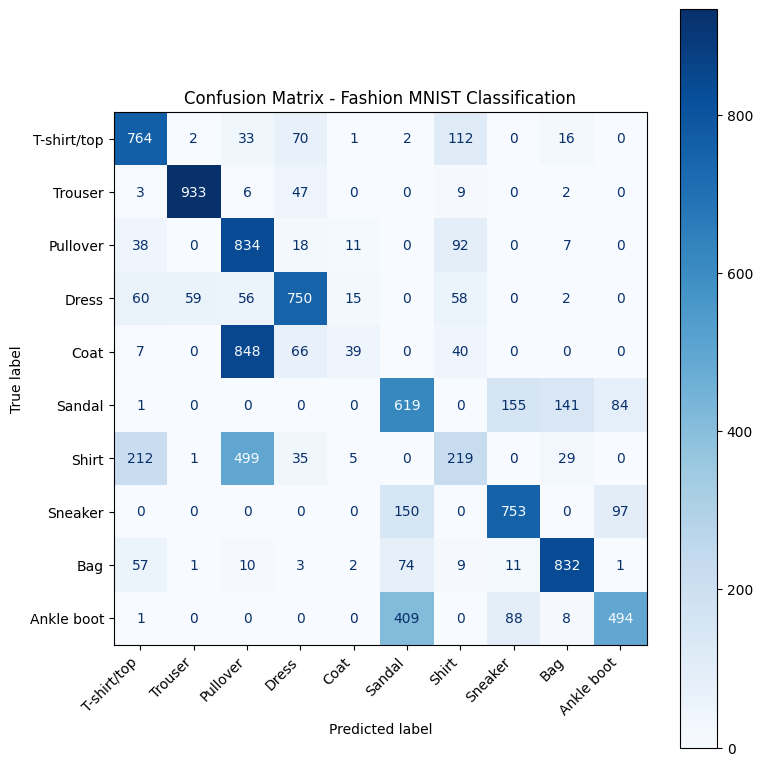

In [684]:
test_images, test_labels, test_preds = calculate_predictions(
    model, current_test_loader, device, just_one_batch=False
)

cm = confusion_matrix(test_labels.cpu(), test_preds.cpu())

# Dynamically get the class names from the dataset
class_names = current_test_loader.dataset.classes
# class_names = current_test_loader.dataset.classes
unique_labels = sorted(test_labels.unique().cpu().tolist())
active_class_names = [class_names[i] for i in unique_labels]

# Automatically determine which classes are actually present
# unique_labels = sorted(test_labels.unique().cpu().tolist())
# active_class_names = [class_names[i] for i in unique_labels]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=active_class_names)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Fashion MNIST Classification", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Answers to Question 2

### 2a/2b

The Loss function and Accuracy scores change

Epoch Loss:
	- Train no RandomHorizontalFlip:
		- Epoch 1, Loss: 1588.8287
		- Epoch 2, Loss: 1167.4809
		- Epoch 3, Loss: 854.3996
  
	- Train w/ RHF and p = 0.5:
		- Epoch 1, Loss: 1235.3606
		- Epoch 2, Loss: 834.9183
		- Epoch 3, Loss: 707.2788

	- Train w/ RHF and p = 1:
		- Epoch 1, Loss: 991.8870
		- Epoch 2, Loss: 598.1880
		- Epoch 3, Loss: 539.6063

Accuracy Score:
	- Train no RandomHorizontalFlip: `73.25%`
	- Train w/ RHF and p = 0.5: `75.60%`
	- Train w/ RHF and p = 1: `52.48%`

### 2c
I would predict that having more variability in random flips would allow for better accuracy, depending on amount of data used.

Loss result:
	- Epoch 1, Loss: 1362.2657
	- Epoch 2, Loss: 887.8049
	- Epoch 3, Loss: 751.7783

Accuracy result: `75.57%`

After running a few times I saw a large shift in accuracy scores, ~5%

## Answer for Question 3

By shuffling the data in train it prevent overfitting by providing better sampling. For example if all the data was ordered by category, shuffling would prevent batches from have bias in each batch. If the values were switched, train would be susceptible to poor learning and the test data would be non deterministic and harder to debug. If both were set to true the model would learn well but train would be hard to determined any issue.

## Answer for 4a

Use `target_transform` and reassign classes array.

```python
# Original 10 classes → New 4 classes mapping
label_mapping = {
    0: 0,  # T-shirt/top → TopWear
    1: 1,  # Trouser → Lower/FullWear
    2: 0,  # Pullover → TopWear
    3: 1,  # Dress → Lower/FullWear
    4: 0,  # Coat → TopWear
    5: 2,  # Sandal → ShoeWear
    6: 0,  # Shirt → TopWear
    7: 2,  # Sneaker → ShoeWear
    8: 3,  # Bag → Accessories
    9: 2,  # Ankle boot → ShoeWear
}

new_classes = ['TopWear', 'Lower/FullWear', 'ShoeWear', 'Accessories']

# Create datasets with target_transform
train_data = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=lambda y: label_mapping[y]
)

test_data = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=lambda y: label_mapping[y]
)

# ← ADD THIS: Override the class names
train_data.classes = new_classes
test_data.classes = new_classes

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Now when you use show_predictions, it will use the new class names
images, labels, preds = calculate_predictions(model, train_loader, device, just_one_batch=True)
show_predictions(images, labels, preds, train_data.classes)  # ← Will show new names!
```

## Answer for 4b

Can print out values with  `train_data.targets[:20]` - you'll still see values 0-9, not 0-3.
The target original values do not change because `targets_transform` is applied when data is accessed.
print(labels.unique())  # Should show tensor([0, 1, 2, 3]) not [0-9]

## Answer for 5a
Pytorch transforms do not provide access to labels on

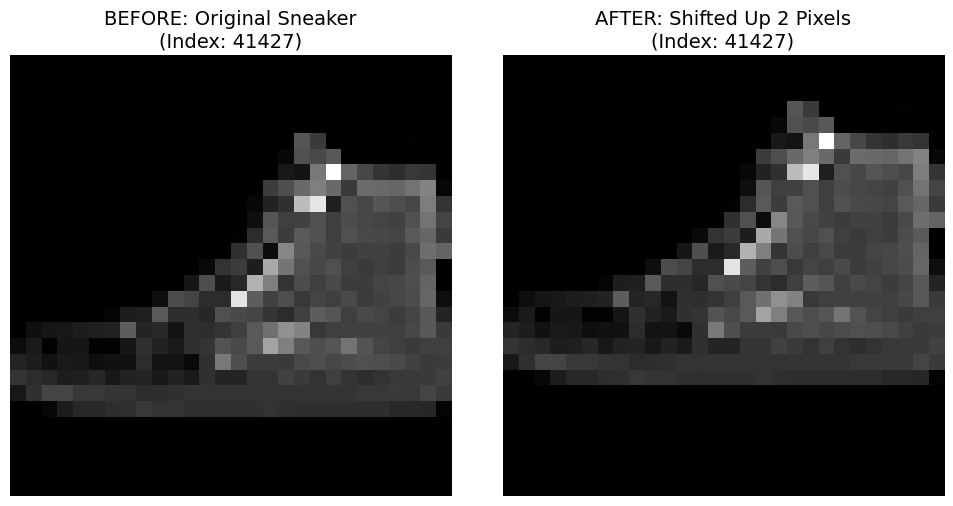

Randomly selected Sneaker at index: 41427
Total Sneakers in dataset: 6000


In [685]:
import random


# Define the shift transform
def shift_up_2_pixels(image):
    """Shift image up by 2 pixels, add blank rows at bottom"""
    shifted = torch.cat(
        [
            image[:, 2:, :],  # Top 26 rows
            torch.zeros(image.shape[0], 2, image.shape[2]),  # 2 blank rows
        ],
        dim=1,
    )
    return shifted

SNEAKER_LABEL = 7

# Load original dataset
original_data = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)

# Find all Sneaker indices
sneaker_indices = [i for i, (_, label) in enumerate(original_data) if label == SNEAKER_LABEL]

# Randomly select one Sneaker
random_sneaker_idx = random.choice(sneaker_indices)

# Get the original image
original_img, label = original_data[random_sneaker_idx]

# Apply shift to create "after" image
shifted_img = shift_up_2_pixels(original_img)

# Visualize side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Before
axes[0].imshow(original_img.squeeze(), cmap="gray")
axes[0].set_title(f"BEFORE: Original Sneaker\n(Index: {random_sneaker_idx})", fontsize=14)
axes[0].axis("off")

# After
axes[1].imshow(shifted_img.squeeze(), cmap="gray")
axes[1].set_title(f"AFTER: Shifted Up 2 Pixels\n(Index: {random_sneaker_idx})", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.show()

print(f"Randomly selected Sneaker at index: {random_sneaker_idx}")
print(f"Total Sneakers in dataset: {len(sneaker_indices)}")


## Answer to 6a
The accuracy of the results was lower with `nn.Dropout(p=0.5)`
Training loss did no change much and even increased on 3rd Epoch

## 6b
I saw poor performance across the board

## 6c

 Dropout is only for training to prevent overfitting. At test time, you want the full network working, so you MUST call model.eval() to turn dropout off.

# Display some predictions on the test set, based on one batch

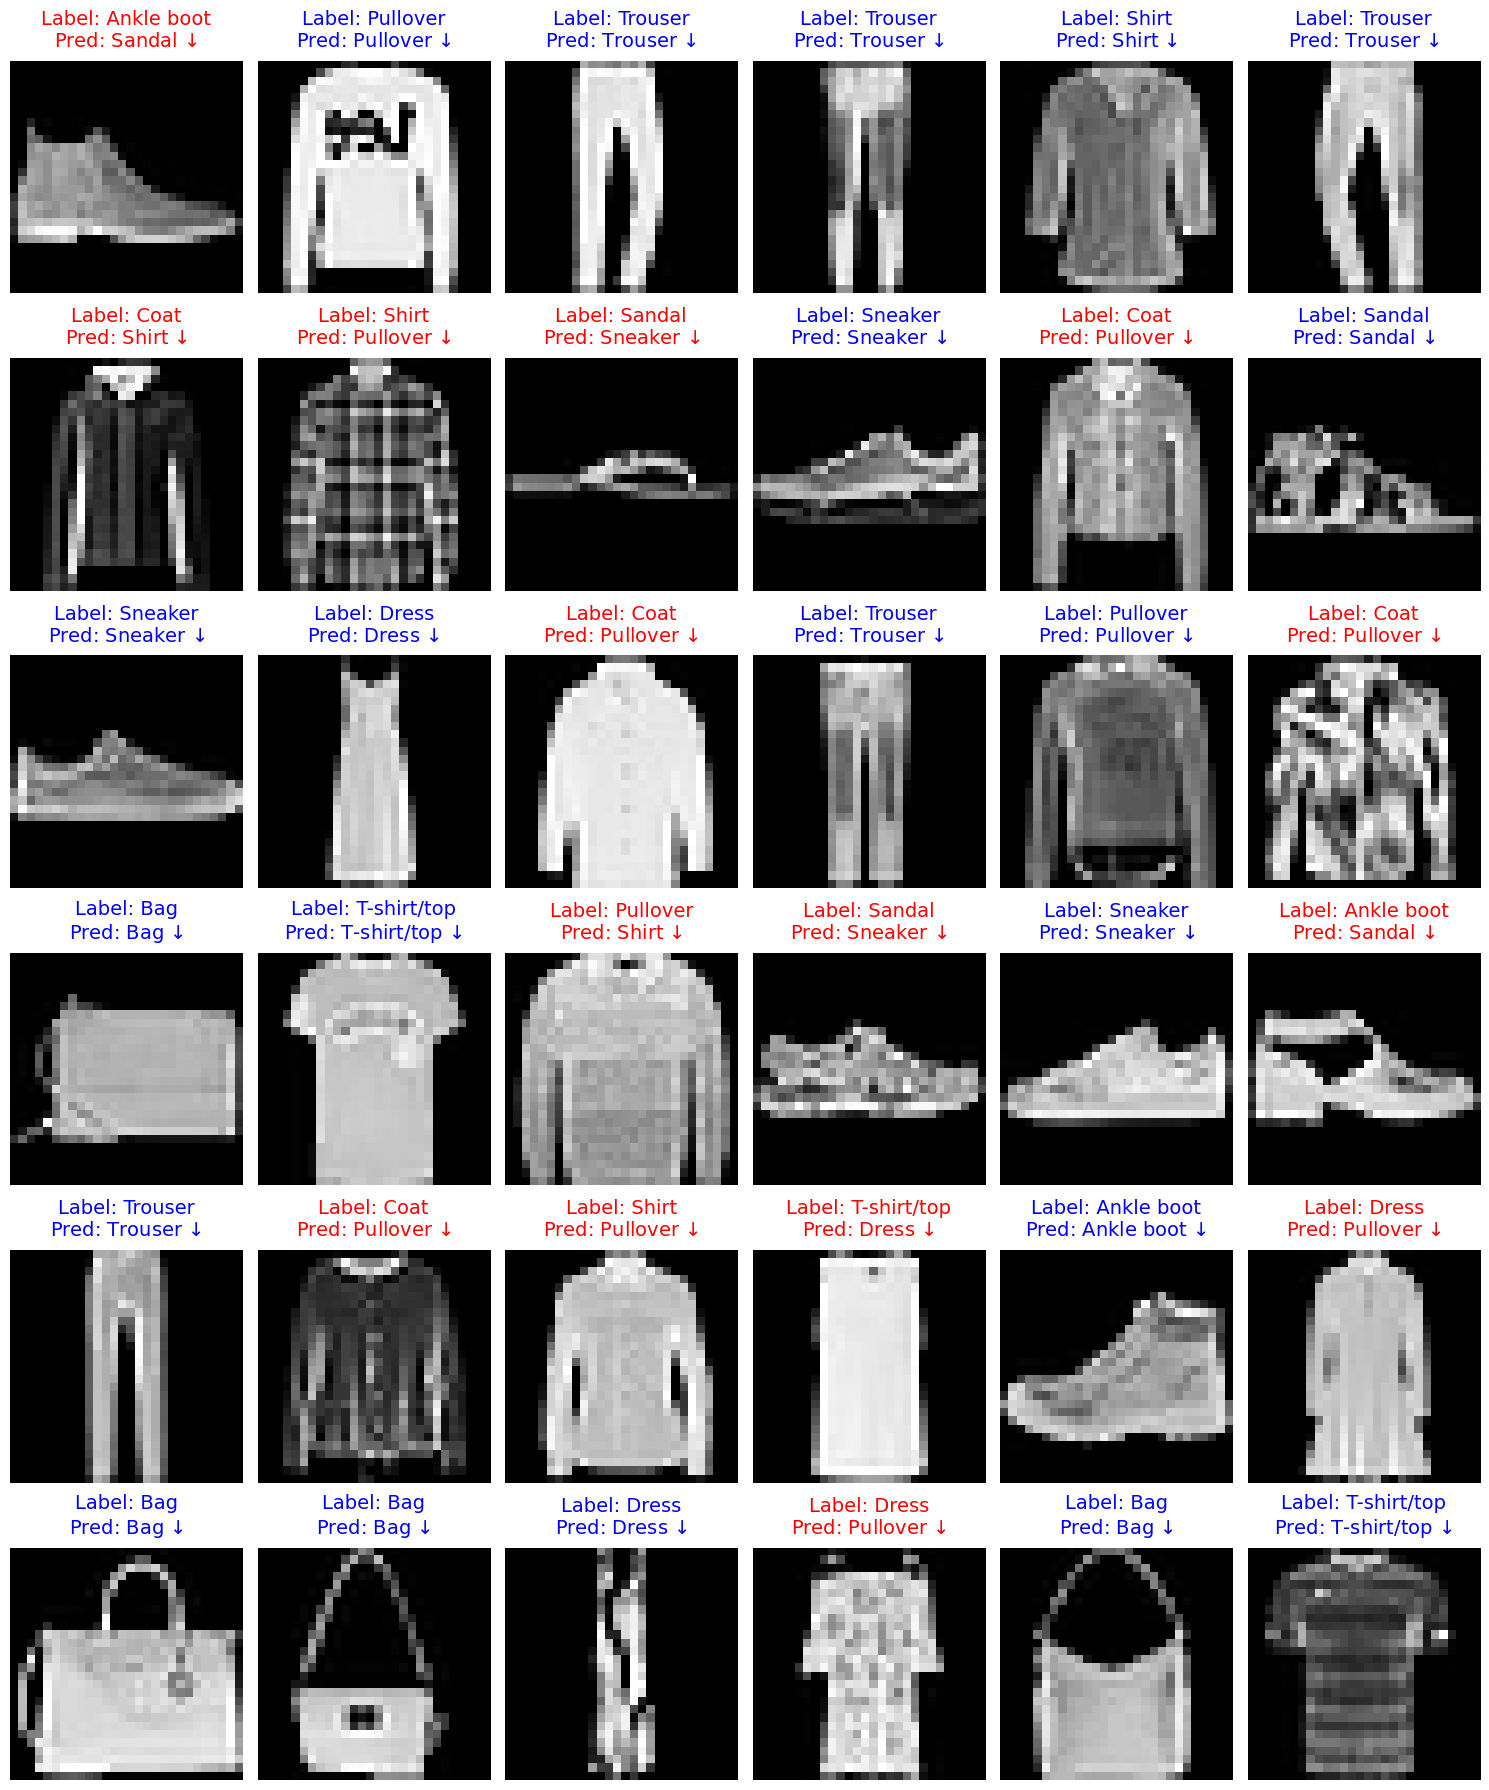

In [686]:
images, labels, preds = calculate_predictions(model, current_test_loader, device, just_one_batch=True)
show_predictions(images, labels, preds, train_data.classes)